In [1]:
%load_ext autoreload

# Studies for SMEFT@NLO discussion in 2022

3 samples, top-W scattering @NLO, ttW_QCD @NLO, ttW_QCD+QED @LO.

All samples are in
/ceph/cms/store/user/dspitzba/ProjectMetis/

TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/

TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/


ttlnuJet_all22WCs_RunIISummer20_NanoGEN_NANO_v26/merged/

TTWToLNu_SM_RunIISummer20_NanoGEN_NANO_v26//merged/


Also use hist instead of coffea hist / yahist / boost histogram --> for future migrations

First, make histograms of the weight distributions of my signal samples. Very basic sanity check.

In [2]:
import awkward as ak
import hist
import glob
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
NanoAODSchema.warn_missing_crossrefs = False

base_dir = '/ceph/cms/store/user/dspitzba/ProjectMetis/'

In [3]:
!ls /ceph/cms/store/user/dspitzba/ProjectMetis//TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/

merged_0.root	merged_13.root	merged_1.root  merged_5.root  merged_9.root
merged_10.root	merged_14.root	merged_2.root  merged_6.root
merged_11.root	merged_15.root	merged_3.root  merged_7.root
merged_12.root	merged_16.root	merged_4.root  merged_8.root


In [4]:
f_in = f'{base_dir}/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/merged_0.root'
topW_TtoLep = NanoEventsFactory.from_root(
    f_in,
    #'/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_60.root',
    schemaclass=NanoAODSchema,
).events()

In [5]:
topW_TtoLep.LHEWeight.fields

['originalXWGTUP',
 'cpt_0p_cpqm_0p_nlo',
 'cpt_3p_cpqm_0p_nlo',
 'cpt_6p_cpqm_0p_nlo',
 'cpt_0p_cpqm_3p_nlo',
 'cpt_0p_cpqm_6p_nlo',
 'cpt_3p_cpqm_3p_nlo']

In [6]:
weight_axis = hist.axis.Regular(50, -1, 20, name="weight_ax", label="weight", underflow=True, overflow=True)

h_0 = hist.Hist(weight_axis)
h_0.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_0p_cpqm_0p_nlo)

h_1 = hist.Hist(weight_axis)
h_1.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_6p_cpqm_0p_nlo)

h_2 = hist.Hist(weight_axis)
h_2.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_0p_cpqm_6p_nlo)

h_3 = hist.Hist(weight_axis)
h_3.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_3p_cpqm_3p_nlo)

Hist(Regular(50, -1, 20, name='weight_ax', label='weight'), storage=Double()) # Sum: 69952.0 (70000.0 with flow)

In [7]:
# number of events with weight > 20 ("problematic")
h_1.values(flow=True)[-1]/sum(h_1.values(flow=True))

0.0024285714285714284

In [8]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

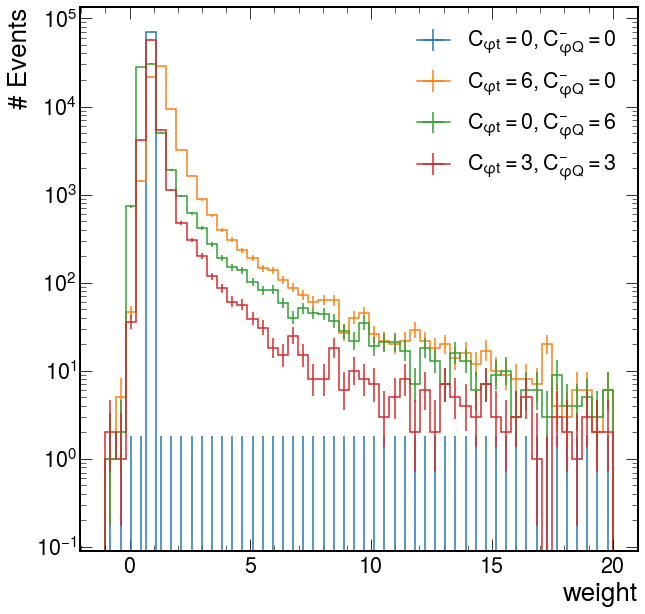

In [9]:
f, ax = plt.subplots()

h_0.plot1d(ax=ax, label=r'$C_{\varphi t}=0, C_{\varphi Q}^{-}=0$')
h_1.plot1d(ax=ax, label=r'$C_{\varphi t}=6, C_{\varphi Q}^{-}=0$')
h_2.plot1d(ax=ax, label=r'$C_{\varphi t}=0, C_{\varphi Q}^{-}=6$')
h_3.plot1d(ax=ax, label=r'$C_{\varphi t}=3, C_{\varphi Q}^{-}=3$')

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'weight')

ax.set_yscale("log")

plt.legend()


In [10]:
ak.mean(topW_TtoLep.LHEWeight.cpt_0p_cpqm_0p_nlo)

0.9999982142857143

In [11]:
len(topW_TtoLep)

70000

## Get the Polynom for the simple case - 2 Wilson coefficients, 6 weights

In [12]:
from Tools.reweighting import get_coordinates, get_coordinates_and_ref
coords, ref_coords = get_coordinates_and_ref(f_in, is2D=True)

In [13]:
from Tools.HyperPoly import HyperPoly  # maybe need awkward hyperpoly

In [14]:
topW_TtoLep.LHEWeight.fields

['originalXWGTUP',
 'cpt_0p_cpqm_0p_nlo',
 'cpt_3p_cpqm_0p_nlo',
 'cpt_6p_cpqm_0p_nlo',
 'cpt_0p_cpqm_3p_nlo',
 'cpt_0p_cpqm_6p_nlo',
 'cpt_3p_cpqm_3p_nlo']

In [15]:
w = topW_TtoLep.LHEWeight
weights = ak.Array([
    w.cpt_0p_cpqm_0p_nlo,
    w.cpt_3p_cpqm_0p_nlo,
    w.cpt_6p_cpqm_0p_nlo,
    w.cpt_0p_cpqm_3p_nlo,
    w.cpt_0p_cpqm_6p_nlo,
    w.cpt_3p_cpqm_3p_nlo,
])

In [16]:
weights[:,0]

<Array [1, 1.45, 2.18, 0.63, 0.548, 0.897] type='6 * float64'>

In [17]:
hp = HyperPoly(2)
hp.initialize( coords, ref_coords )
coeff = hp.get_parametrization(weights)

In [18]:
hp.root_func_string(coeff[1])

'0.100606+0.224482*x0+0.071274*x1-0.015849*x0**2-0.018799*x0*x1+0.049077*x1**2'

In [19]:
coeff[0]

array([1.        , 0.99996948, 0.99996948, ..., 1.        , 1.        ,
       1.        ])

In [20]:
coeff_axis = hist.axis.Regular(50, -2, 2, name="coeff", label="coeff", underflow=True, overflow=True)

ch_0 = hist.Hist(coeff_axis)
ch_0.fill(coeff=coeff[0])

ch_1 = hist.Hist(coeff_axis)
ch_1.fill(coeff=coeff[1])

ch_2 = hist.Hist(coeff_axis)
ch_2.fill(coeff=coeff[2])

ch_3 = hist.Hist(coeff_axis)
ch_3.fill(coeff=coeff[3])

ch_4 = hist.Hist(coeff_axis)
ch_4.fill(coeff=coeff[4])

ch_5 = hist.Hist(coeff_axis)
ch_5.fill(coeff=coeff[5])

Hist(Regular(50, -2, 2, name='coeff', label='coeff'), storage=Double()) # Sum: 69971.0 (70000.0 with flow)

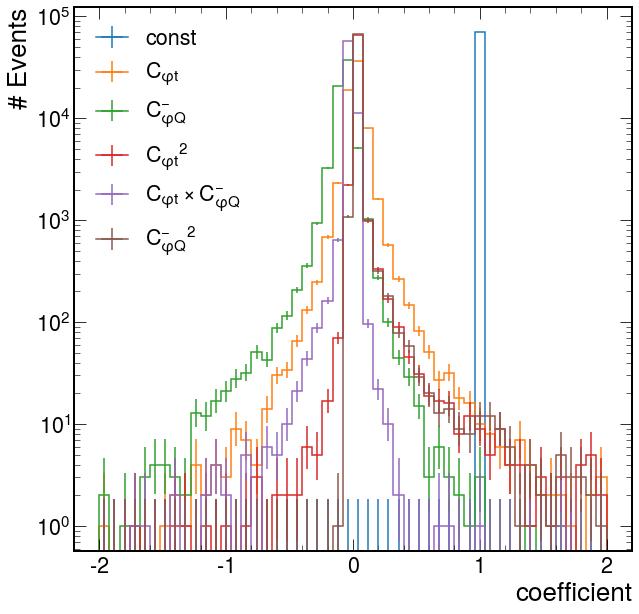

In [21]:
f, ax = plt.subplots()

ch_0.plot1d(ax=ax, label=r'const')
ch_1.plot1d(ax=ax, label=r'$C_{\varphi t}$')
ch_2.plot1d(ax=ax, label=r'$C_{\varphi Q}^{-}$')
ch_3.plot1d(ax=ax, label=r'${C_{\varphi t}}^{2}$')
ch_4.plot1d(ax=ax, label=r'$C_{\varphi t} \times C_{\varphi Q}^{-}$')
ch_5.plot1d(ax=ax, label=r'${C_{\varphi Q}^{-}}^{2}$')


ax.set_ylabel(r'# Events')
ax.set_xlabel(r'coefficient')

ax.set_yscale("log")

plt.legend()

In [22]:
topW_TtoLep.GenDressedLepton.pdgId

<Array [[11], [-13, -11], ... -13], [-11, 13]] type='70000 * var * int32[paramet...'>

## Multidimensional LO ttW sample

In [23]:
import numpy as np
import itertools

from Tools.reweighting import eft_point, eft_setup

In [24]:
f_in = f'{base_dir}/ttlnuJet_all22WCs_RunIISummer20_NanoGEN_NANO_v26/merged/merged_0.root'
events = NanoEventsFactory.from_root(
    f_in,
    #'/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_60.root',
    schemaclass=NanoAODSchema,
).events()

In [25]:
test = eft_setup('../production/cards/ttlnuJet_all22WCs/ttlnuJet_all22WCsStartPtCheckdim6TopMay20GST_run0_customizecards.dat', events)

In [26]:
weight_names = events.LHEWeight.fields#[:276]
weights = [getattr(events.LHEWeight, w) for w in weight_names[2:]]
w = np.array(weights)

In [27]:
combination  = {}
counter = 0
order = 2
nvar = 22
for o in range(order+1):
    for comb in itertools.combinations_with_replacement( range(nvar), o ):
        combination[counter] = comb
        counter += 1

m = 332
n = int((nvar+1)*(nvar+2)/2)
A = np.empty( [m, n ] )
param_points = test.get_coordinates()
ref_point = test.get_ref_point()
combinations = list(combination.values())
for d in range(m):
    for e in range(n):
        A[d][e] = np.prod([param_points[d][x]-ref_point[x] for x in combinations[e]])

In [28]:
res = np.linalg.lstsq(A, w, rcond=None)

In [57]:
new_point = [0]*n
sm_vec = [ np.prod([new_point[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]
sm_weight = np.dot(res[0].T, sm_vec)
sum(sm_weight)

20701.341098513494

In [161]:
test_point = eft_point.from_customize_card('../production/cards/ttlnuJet_all22WCs/ttlnuJet_all22WCsStartPtCheckdim6TopMay20GST_run0_customizecards.dat')
test_point.set({"cpt":20.0, "cpQM":0.0}, reset=True)
test_point.show()
bsm_vec = [ np.prod([test_point.get_coord()[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]
bsm_weight = np.dot(res[0].T, bsm_vec)
sum(bsm_weight)/sum(sm_weight)

   ctlTi  ctq1  ctq8  cQlMi  cQq81  cQq83  cbW  cpQ3  ctei  ctlSi  ...  cQei  \
0      0     0     0      0      0      0    0     0     0      0  ...     0   

   ctZ  cQl3i  ctG  cQq13  cQq11  cptb  ctli  ctp   cpt  
0    0      0    0      0      0     0     0    0  20.0  

[1 rows x 22 columns]


1.4547632358735978

In [151]:
'''
test_scan = []

for i in range(-20,21):
    test_point.set({"cpt":i, "cpQM":0.0, "ctZ":0}, reset=True)
    bsm_vec = [ np.prod([test_point.get_coord()[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]
    bsm_weight = np.dot(res[0].T, bsm_vec)
    print (i, sum(bsm_weight)/sum(sm_weight))
    test_scan.append(sum(bsm_weight)/sum(sm_weight))
'''

-20 1.3604746896160322
-19 1.323089054404864
-18 1.2877415140073882
-17 1.2544320684236774
-16 1.2231607176536614
-15 1.1939274616973852
-14 1.16673230055482
-13 1.1415752342259797
-12 1.118456262710871
-11 1.0973753860094995
-10 1.0783326041218286
-9 1.0613279170478842
-8 1.0463613247876773
-7 1.0334328273411837
-6 1.0225424247084063
-5 1.013690116889371
-4 1.0068759038840553
-3 1.0020997856924692
-2 0.9993617623145915
-1 0.9986618337504402
0 1.0
1 1.003376261063333
2 1.0087906169403362
3 1.016243067631093
4 1.0257336131355674
5 1.0372622534537568
6 1.0508289885856739
7 1.0664338185313373
8 1.0840767432906946
9 1.1037577628637845
10 1.1254768772506178
11 1.1492340864511246
12 1.1750293904654237
13 1.202862789293404
14 1.2327342829351327
15 1.2646438713905401
16 1.2985915546597089
17 1.334577332742613
18 1.372601205639216
19 1.4126631733495538
20 1.4547632358735978


In [32]:
np.dot(res[0].T, sm_vec)

array([3.65372246e-03, 1.00553804e-06, 8.08841467e-01, ...,
       5.71731841e-05, 2.28950603e-01, 5.41300824e-02])

In [33]:
print (weight_names[-1])
getattr(events.LHEWeight, weight_names[-1])[0]

EFTrwgt331_ctlTi_0.0_ctq1_0.0_ctq8_0.0_cQq83_0.0_cQq81_0.0_cQlMi_0.0_cbW_0.0_cpQ3_0.0_ctei_0.0_cQei_0.0_ctW_0.0_cpQM_0.0_ctlSi_0.0_ctZ_0.0_cQl3i_0.0_ctG_0.0_cQq13_0.0_cQq11_0.0_cptb_0.0_ctli_0.0_ctp_0.0_cpt_0.0


0.003650188446044922

In [34]:
len(events)

65699

In [33]:
np.dot(res[0].T, sm_vec)

0.003653722425962921

In [34]:
getattr(events.LHEWeight, weight_names[-1])

<Array [0.00365, 0, 0.809, ... 0.229, 0.0541] type='65699 * float32[parameters={...'>

In [162]:
class EFT_analysis(processor.ProcessorABC):
    def __init__(self):
        lt_axis = hist.axis.Regular(20, 0, 1000, name="lt", label="$L_{T}$ (GeV)")

        self.make_output = lambda: {
            'lt_sm': hist.Hist(lt_axis),
            'lt': hist.Hist(lt_axis),
            "EventCount": processor.value_accumulator(int),
            "sumw": processor.value_accumulator(float),
        }
        
        ######

    def process(self, events):
        output = self.make_output()

        dataset = events.metadata['dataset']
        
        output["EventCount"] = len(events) 
        output["sumw"] = ak.sum(events.genWeight)
        
        sm_weight = np.ones(len(events))
        
        isEFT = False
        is2D = False
        if hasattr(events.LHEWeight, 'cpt_0p_cpqm_0p_nlo'):
            isEFT = True
            is2D = True
        elif hasattr(events.LHEWeight, weight_names[-1]):
            isEFT = True
            is2D = False
        
        if isEFT and is2D:
            w = events.LHEWeight
            weights = ak.Array([
                w.cpt_0p_cpqm_0p_nlo,
                w.cpt_3p_cpqm_0p_nlo,
                w.cpt_6p_cpqm_0p_nlo,
                w.cpt_0p_cpqm_3p_nlo,
                w.cpt_0p_cpqm_6p_nlo,
                w.cpt_3p_cpqm_3p_nlo,
            ])

            coeff = hp.get_parametrization(weights)
            bsm_weight = hp.eval(coeff, [20, 0])
            
        elif isEFT and not is2D:
            w = [getattr(events.LHEWeight, w) for w in weight_names[2:]]  # cut away garbage weights
            res = np.linalg.lstsq(A, w, rcond=None)  # solve the linear equation system
            
            sm_weight = np.dot(res[0].T, sm_vec)
            bsm_weight = np.dot(res[0].T, bsm_vec)
        
        met = events.GenMET
        lepton = events.GenDressedLepton
        jet = events.GenJet
        
        sel_jet = jet[((jet.pt>25)&(abs(jet.eta)<2.4))]
        
        lt = met.pt + ak.sum(lepton.pt[:,:2], axis=1)
        
        ######
        
        event_sel = ((ak.num(lepton)==2) & (ak.sum(lepton.pdgId, axis=1)>0) & (ak.num(sel_jet)>3))
        
        if isEFT:
            output['lt'].fill(
                lt=lt[event_sel],
                weight=(events.genWeight*bsm_weight)[event_sel],  # NOTE: signs of weights checked.
            )

        output['lt_sm'].fill(
            lt=lt[event_sel],
            weight=(events.genWeight*sm_weight)[event_sel],
        )
                
        return {dataset: output}

    def postprocess(self, accumulator):
        return accumulator

In [189]:
fileset = {
    "ttlnuJet": glob.glob(f"{base_dir}/ttlnuJet_all22WCs_RunIISummer20_NanoGEN_NANO_v26/merged/*.root")[:-1],
    "TTWToLNu_TtoLep_aTtoHad": glob.glob(f"{base_dir}/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/*.root")[:-1],
    "TTWToLNu_TtoAll_aTtoLep": glob.glob(f"{base_dir}/TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/*.root")[:-1],
    "TTWToLNu_SM": glob.glob(f"{base_dir}/TTWToLNu_SM_RunIISummer20_NanoGEN_NANO_v26/merged/*.root")[:-1],

}

output = processor.run_uproot_job(
    fileset,
    "Events",
    EFT_analysis(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
    chunksize=25000,
)

Output()

Output()

In [192]:
# SM point of LO ttlnu + jet sample MG x-sec: 0.326962929058 +- 0.0239820601814 pb (without matching)
# 
xsecs = {
    "TTWToLNu_TtoLep_aTtoHad": 3.420e-3, # 3.732e-3, # old number
    "TTWToLNu_TtoAll_aTtoLep": 5.060e-3, # 5.521e-3, # old number
    "TTWToLNu_SM": 0.2043,
    "ttlnuJet": 4.848e-01, # this number is from NanoGEN production log, 0.54639 before matching from gridpack step
}

In [193]:
output["TTWToLNu_TtoLep_aTtoHad"]["EventCount"]

1120000

In [194]:
output["ttlnuJet"]["lt_sm"]

Hist(Regular(20, 0, 1000, name='lt', label='$L_{T}$ (GeV)'), storage=Double()) # Sum: 9245.919327086776 (9253.487019597027 with flow)

In [195]:
output["ttlnuJet"]["lt"]

Hist(Regular(20, 0, 1000, name='lt', label='$L_{T}$ (GeV)'), storage=Double()) # Sum: 13361.491754519557 (13477.899586244075 with flow)

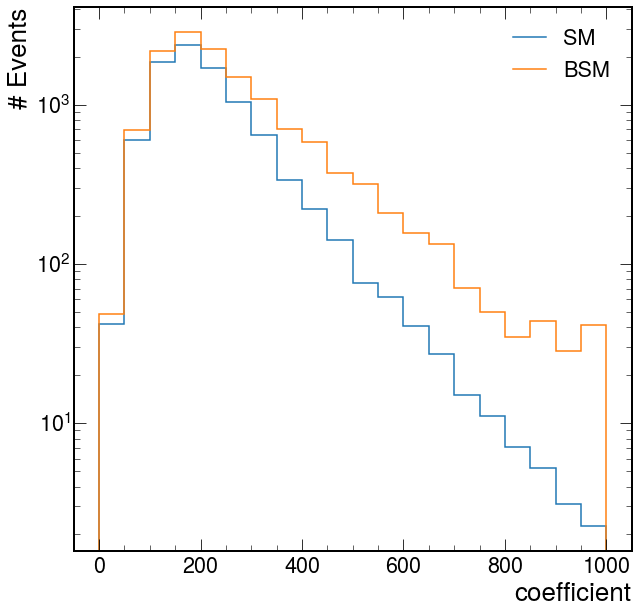

In [196]:
f, ax = plt.subplots()

output["ttlnuJet"]["lt_sm"].plot1d(ax=ax, label=r'SM')
output["ttlnuJet"]["lt"].plot1d(ax=ax, label=r'BSM')


ax.set_ylabel(r'# Events')
ax.set_xlabel(r'coefficient')

ax.set_yscale("log")

plt.legend()

### SM comparison

In [197]:
LO_h = output["ttlnuJet"]["lt_sm"].copy()
NLO_QCD_h = output["TTWToLNu_SM"]["lt_sm"].copy()
NLO_QED1_h = output["TTWToLNu_TtoLep_aTtoHad"]["lt_sm"].copy()
NLO_QED2_h = output["TTWToLNu_TtoAll_aTtoLep"]["lt_sm"].copy()

In [198]:
LO_h_scaled = LO_h*137*1000*xsecs["ttlnuJet"]/output["ttlnuJet"]["sumw"]
NLO_QCD_h_scaled = NLO_QCD_h*137*1000*xsecs["TTWToLNu_SM"]/output["TTWToLNu_SM"]["sumw"]
NLO_QED1_h_scaled = NLO_QED1_h*137*1000*xsecs["TTWToLNu_TtoLep_aTtoHad"]/output["TTWToLNu_TtoLep_aTtoHad"]["sumw"]
NLO_QED2_h_scaled = NLO_QED2_h*137*1000*xsecs["TTWToLNu_TtoAll_aTtoLep"]/output["TTWToLNu_TtoAll_aTtoLep"]["sumw"]

In [199]:
norm = (sum(NLO_QED1_h_scaled.values())+sum(NLO_QED2_h_scaled.values())+sum(NLO_QCD_h_scaled.values()))/(sum(LO_h_scaled.values()))

In [200]:
LO_h_scaled = LO_h_scaled*norm

In [201]:
sum(NLO_QCD_h_scaled.values())

2528.3466768241765

In [202]:
sum(NLO_QED1_h_scaled.values())+sum(NLO_QED2_h_scaled.values())

188.24968352503214

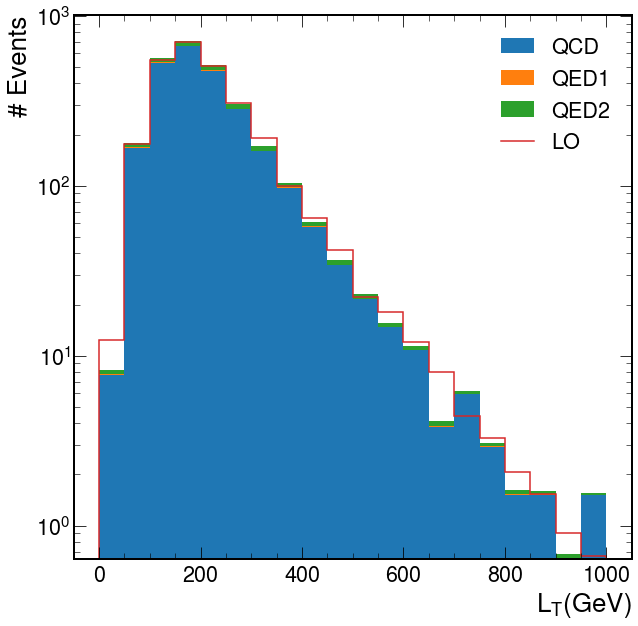

In [203]:
f, ax = plt.subplots()

hep.histplot(
    [NLO_QCD_h_scaled.values(), NLO_QED1_h_scaled.values(), NLO_QED2_h_scaled.values()],
    NLO_QCD_h.axes[0].edges,
    #density=True,
    histtype='fill',
    stack=True,
    label=['QCD', 'QED1', 'QED2']
)

hep.histplot(
    [LO_h_scaled.values()],
    LO_h.axes[0].edges,
    #density=True,
    label=['LO']
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")

plt.legend()

### BSM comparison

In [204]:
LO_bsm_h = output["ttlnuJet"]["lt"].copy()
NLO_QCD_bsm_h = output["TTWToLNu_SM"]["lt"].copy()
NLO_QED1_bsm_h = output["TTWToLNu_TtoLep_aTtoHad"]["lt"].copy()
NLO_QED2_bsm_h = output["TTWToLNu_TtoAll_aTtoLep"]["lt"].copy()

In [205]:
LO_bsm_h_scaled = LO_bsm_h*137*1000*xsecs["ttlnuJet"]/output["ttlnuJet"]["sumw"]
NLO_QCD_bsm_h_scaled = NLO_QCD_bsm_h*137*1000*xsecs["TTWToLNu_SM"]/output["TTWToLNu_SM"]["sumw"]
NLO_QED1_bsm_h_scaled = NLO_QED1_bsm_h*137*1000*xsecs["TTWToLNu_TtoLep_aTtoHad"]/output["TTWToLNu_TtoLep_aTtoHad"]["sumw"]
NLO_QED2_bsm_h_scaled = NLO_QED2_bsm_h*137*1000*xsecs["TTWToLNu_TtoAll_aTtoLep"]/output["TTWToLNu_TtoAll_aTtoLep"]["sumw"]

In [206]:
LO_bsm_h_scaled = LO_bsm_h_scaled * norm

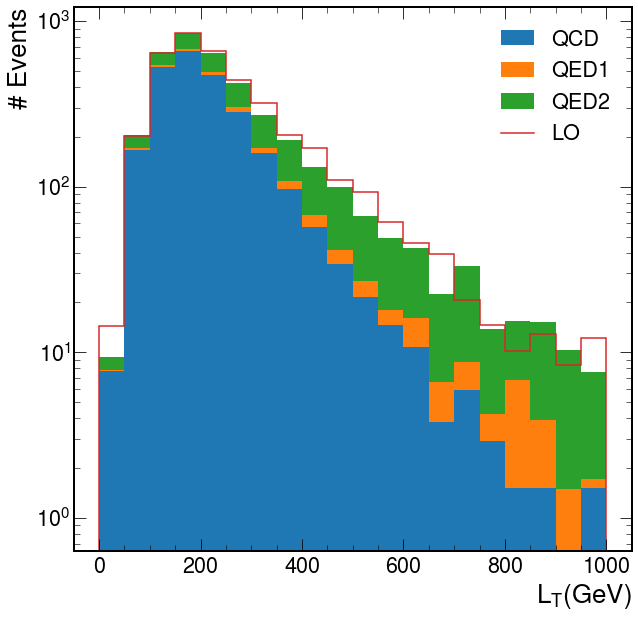

In [207]:
f, ax = plt.subplots()

hep.histplot(
    [NLO_QCD_h_scaled.values(), NLO_QED1_bsm_h_scaled.values(), NLO_QED2_bsm_h_scaled.values()],
    NLO_QCD_h.axes[0].edges,
    #density=True,
    histtype='fill',
    stack=True,
    label=['QCD', 'QED1', 'QED2']
)

hep.histplot(
    [LO_bsm_h_scaled.values()],
    LO_h.axes[0].edges,
    #density=True,
    label=['LO']
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")

plt.legend()

In [214]:
sum(LO_bsm_h_scaled.values(flow=True))

3960.0186488625986

In [215]:
sum(LO_h_scaled.values(flow=True))

2718.8198673042566

In [216]:
sum(NLO_QED1_bsm_h_scaled.values(flow=True))+sum(NLO_QED2_bsm_h_scaled.values(flow=True))

1248.8020505685408

In [217]:
sum(NLO_QED1_h_scaled.values(flow=True))+sum(NLO_QED2_h_scaled.values(flow=True))

188.35167605286998

In [218]:
sum(NLO_QED1_h_scaled.values(flow=True))+sum(NLO_QED2_h_scaled.values(flow=True))+sum(NLO_QCD_h_scaled.values(flow=True))

2719.102686553706

In [219]:
sum(NLO_QED1_bsm_h_scaled.values(flow=True))+sum(NLO_QED2_bsm_h_scaled.values(flow=True))+sum(NLO_QCD_h_scaled.values(flow=True))

3779.553061069377

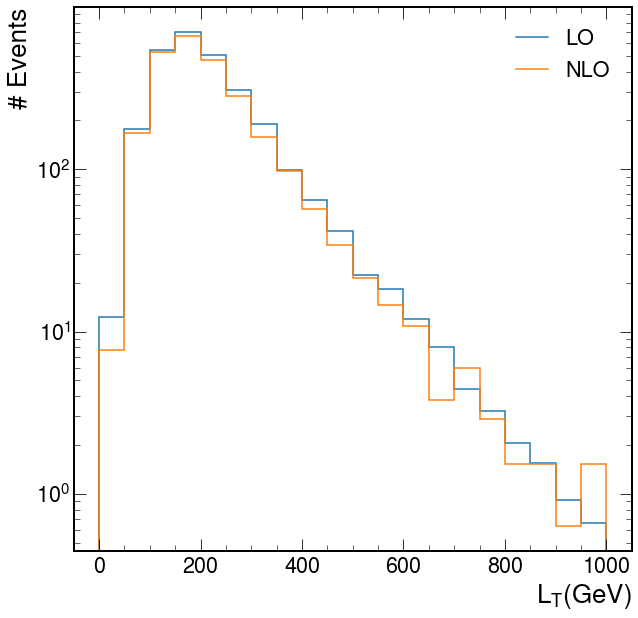

In [220]:
f, ax = plt.subplots()

hep.histplot(
    [LO_h_scaled.values(), NLO_QCD_h_scaled.values()],
    LO_h.axes[0].edges,
    #density=True,
    label=['LO', 'NLO']
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")

plt.legend()

In [43]:
mapping = {
    "LO": [
        "ttlnuJet",
    ],
    "NLO":[
        "TTWToLNu_SM",
        "TTWToLNu_TtoAll_aTtoLep",
        "TTWToLNu_TtoLep_aTtoHad"
    ],
}

In [52]:
lt_axis = hist.axis.Regular(20, 0, 1000, name="lt", label="$L_{T}$ (GeV)")

In [55]:
RebinHist(output["ttlnuJet"]["lt"], lt=lt_axis)

ValueError: bins > 0 required

In [50]:
# Taken from Yi-Mu: https://gist.github.com/yimuchen/a5e200c001ef4ea01681a7dd8fe89162#file-integrate_and_rebin-py-L158
def RebinHist(h, **kwargs):
    """
    Rebinning a scikit-hist histogram. 2 types of values can be accepted as the
    argument values:
    - Derivatives of the `hist.rebin` argument. In this case we directly use the
    UHI facilities to perform the rebinning.
    - A new axis object where all the bin edges lands on the old bin edges of the
    given histogram. In this case a custom intergration loop is performed to
    extract the rebinning. Beware that this methods is very slow, as it requires
    a loop generation of all possible UHI values after the rebinning, so be sure
    that rebinning is performed as the final step of the histogram reduction. See
    `_rebin_single_scikit` for more information regarding this method.
    """
    h = h.copy()
    for var, var_val in kwargs.items():
        if isinstance(var_val, hist.rebin):
            h = h[{var: var_val}]
        else:
            h = _rebin_single_scikit(h, var, var_val)
    return h


def __check_scikit_axis_compat(axis1, axis2):
    """
    Checking that axis 2 is rebin-compatible with axis 1. This checks that:
    1. The two histogram share the same name.
    2. The edges of the second axis all land on the edges of the first axis.
    If the two axis are compatible the function will return an array of the bin
    index of the axis 1 that the bin edges of axis 2 falls on.
    """
    assert axis1.name == axis2.name, \
    'Naming of the axis is required to match'
    # Getting the new bin edges index for the old bin edges
    try:
        return [
        np.argwhere(axis1.edges == new_edge)[0][0] for new_edge in axis2.edges
        ]
    except IndexError as err:
        raise ValueError(f"Bin edges of the axis {axis2} is incompatible with {axis1}")


def _get_all_indices(axis):
    """
    Getting all possible (integer) bin index values given a scikit-hep histogram.
    The special indices of hist.underflow and hist.overflow will be included if the
    axis in questions has those traits.
    """
    idxs = list(range(len(axis)))
    if axis.traits.underflow:  # Extension to include the under/overflow bins
        idxs.insert(0, hist.underflow)
        if axis.traits.overflow:
            idxs.append(hist.overflow)
    return idxs


def _rebin_single_scikit(h, old_axis, new_axis):
    """
    Rebinning a single axis of a scikit-hist histogram. This includes the following
    routines:
    - Generating a new scikit hep instance that perserves axis ordering with the
    exception of the rebinned axis (in place) replacement.
    - Setting up the integration ranges required to calculate the bin values of the
    new histogram.
    - Looping over the UHI values of the new histogram and performing the a
    summation over the specified range on the old histogram to fill in the new
    values.
    As here we have variable number of axis each with variable number of bins, this
    method will require the use of more old fashioned python looping, which can be
    very slow for large dimensional histograms with many bins for each axis. So be
    sure to make rebinning be the final step in histogram reduction.
    """

    #assert isinstance(h, hist.NamedHist), "Can only process named histograms"

    # Additional type casing
    if type(old_axis) == str:
        return _rebin_single_scikit(h, h.axes[old_axis], new_axis)
    axis_name = old_axis.name

    ## Creating the new histogram instance with identical axis ordering.
    all_axes = list(h.axes)
    all_axes[all_axes.index(old_axis)] = new_axis
    h_rebinned = hist.NamedHist(*all_axes, storage=h._storage_type())

    # Getting the all possible bin indices for all axes in the old histogram
    bin_idx_dict = {ax.name: _get_all_indices(ax) for ax in h.axes}

    # Getting the new bin edges index for the old bin edges
    new_bin_edge_idx = __check_scikit_axis_compat(old_axis, new_axis)
    if new_axis.traits.underflow:  # Adding additional underflow/overflow
        new_bin_edge_idx.insert(0, bin_idx_dict[axis_name][0])
        if new_axis.traits.overflow:
            new_bin_edge_idx.append(bin_idx_dict[axis_name][-1])

    # Generating a the int range pair. Additional parsing will be required for the
    # under/overflow bins

    def make_slice(index):

        start = new_bin_edge_idx[index]
        stop = new_bin_edge_idx[index + 1]
        if start == hist.underflow:
            start = -1
        if stop == hist.overflow:
            stop = len(old_axis)
        return slice(int(start), int(stop))

    new_axis_idx = _get_all_indices(new_axis)
    new_int_slice = [make_slice(i) for i in range(len(new_axis_idx))]
    assert len(new_axis_idx) == len(new_bin_edge_idx) - 1

    new_idx_dict = bin_idx_dict.copy()
    new_idx_dict[axis_name] = new_axis_idx
    bin_idx_dict[axis_name] = new_int_slice

    name_list = list(bin_idx_dict.keys())
    new_idx = [x for x in itertools.product(*[x for x in new_idx_dict.values()])]
    old_int = [x for x in itertools.product(*[x for x in bin_idx_dict.values()])]

    for o, n in zip(old_int, new_idx):
        n_uhi = {name: n[name_idx] for name_idx, name in enumerate(name_list)}
        o_uhi = {name: o[name_idx] for name_idx, name in enumerate(name_list)}
        # Single variable histogram, with just the axis of interest
        h_rebinned[n_uhi] = integrate_hist_scikit(h, **o_uhi)

    return h_rebinned

def integrate_hist_scikit(h, **kwargs):
    """
    Given a scikit-hist histogram object return a reduced histogram with specified
    axes integrated out.
    For scikit-hist histograms, the integration should be formed in 3 steps:
    - slicing the histogram to contain only the range of interest
    - Setting overflow values to 0 (excluding the values from future calculations)
    - Summing over the axes of interest.
    The latter 2 steps will only be carried out if the var_slice doesn't uniquely
    identify a singular bin in the histogram axis
    """
    # Reduction in parallel.
    r = h[kwargs]
    for var, var_slice in kwargs.items():
        # In the case that histogram has been reduced to singular value simple return
        #if not isinstance(r, hist.NamedHist):
        #    return r
        if var in [x.name for x in r.axes]:
            ax = h.axes[var]
            
            get_underflow = var_slice.start == None or var_slice.start == -1
            get_overflow = var_slice.stop == None or var_slice.stop == len(ax)
            if not get_underflow and ax.traits.underflow:
                r[{var: hist.underflow}] = np.zeros_like(r[{var: hist.underflow}])
            if not get_overflow and ax.traits.overflow:
                r[{var: hist.overflow}] = np.zeros_like(r[{var: hist.overflow}])
                
            # Sum over all remaining elements on axis
            r = r[{var: sum}]
    return r
